# Introduction

## Linear Regression

* Gradients were previously discussed in the context of the <b>gradient descent</b> algorithm for fitting linear regression models.

* For a regression model with $n$ parameters, it defines an $n+1$ dimensional space, encompassing all parameters and the cost/loss function.

* The combination of parameters and the loss function defines a <b>surface</b> within this space.

* Fitting the regression model involves descending along the steepest <i>downhill</i> gradient until the lowest (i.e., minimum) point of the surface is reached, where all possible gradients become <i>uphill</i>.

* The final model comprises the parameter estimates corresponding to that location on the surface.

## Gradient Boosting

> <b>NOTE:</b> Throughout all iterations of the gradient descent algorithm for <b>linear regression</b>, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function <i>never changes</i>. In <b>gradient boosting</b>, however, the underlying data <i>do change</i>.  

* In the Gradient Boosting, with each decision tree iteration, we extract the <b>residuals</b>.
A new decision tree is then run, using these residuals as the outcome to predict.

* After reaching a <b>stopping point</b>, we aggregate (i.e, sum) the predicted values from <i>all</i> decision trees to form the final gradient-boosted prediction.

* Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.

* Most commonly, gradient boosting uses decision trees, and minimizes either the  <b>residual (regression trees)</b> or the <b>negative log-likelihood (classification trees)</b> .  

# Dependencies

In [ ]:
import re
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

## <code><b>plot_predictions()</b></code>

In [ ]:
def plot_predictions(
      regressors
    , X
    , y
    , axes
    , label      = None
    , style      = "r-"
    , data_style = "b."
    , data_label = None
  ):

  """
  Plot predictions made by regression models along with the actual data points.

  Parameters:
  - regressors (list of regressor objects): A list of regression models.
  - X (numpy.ndarray): Input feature(s) for making predictions.
  - y (numpy.ndarray): Actual target values.
  - axes (list or tuple of length 4): Axis limits for the plot in [xmin, xmax, ymin, ymax] format.
  - label (str, optional): Label for the predicted curve (for legend).
  - style (str, optional): Style of the predicted curve in the plot.
  - data_style (str, optional): Style of the data points in the plot.
  - data_label (str, optional): Label for the data points (for legend).

  Returns:
  None
  """

  # Create 500 evenly spaced x-values that span the range specified by
  # axes[0] (minimum x-value) and axes[1] (maximum x-value). For example, if
  # "axes=[-0.5, 0.5, -0.1, 0.8]", "x1" below will be an array of 500 evenly
  # spaced values that span the range of [axes[0], axes[1]]=[-0.5, 0.5].
  x1 = np.linspace(
        axes[0]
      , axes[1]
      , 500
  )

  # Reshape "x1" from 1D into a 2D array where each value is in a separate row
  # and a single column. For example, if "x1=[1, 2, 3, 4, 5]", the .reshape(-1,1)
  # will reshape it into:
  # [[1],
  #  [2],
  #  [3],
  #  [4],
  #  [5]]
  x1_reshaped = x1.reshape(-1, 1)

  # Calculate predictions from each regressor in the list "regressors".
  predictions = [
      regressor.predict(x1_reshaped)
      for regressor
      in regressors
  ]

  # Sum up the predicted values from all the regression models in "predictions".
  # Since each regression model produces a set of predicted values for the
  # same "x1" input, summing them up effectively combines the predictions from
  # all models into a single set of predictions represented by "y_pred".
  y_pred = np.sum(
        predictions
      , axis = 0
  )
  # ---------------------------------------------------------------------------
  # Plot actual data
  plt.plot(
        X[:, 0]
      , y
      , data_style
      , label = data_label
  )
  # ---------------------------------------------------------------------------
  # Plot predictions
  plt.plot(
        x1
      , y_pred
      , style
      , label     = label
      , linewidth = 2
  )
  # ---------------------------------------------------------------------------
  if label or data_label:
      plt.legend(
            loc      = "upper center"
          , fontsize = 16
      )
  # ---------------------------------------------------------------------------
  plt.axis(axes)

# 1. Regression

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called <b>Gradient Tree Boosting</b>, or <b>Gradient Boosted Regression Trees</b>. First, let's fit a <code><b>DecisionTreeRegressor</b></code> to the training set.

## 1.1. Train/Test split (<code><b>X</b></code> and <code><b>y</b></code>)

### 1.1.1. <code><b>X</b></code>

1. Set the seed for the NumPy random number generator to <code><b>42</b></code>.
  * Setting a random seed ensures that the random numbers generated later in the code will be reproducible.
  * In other words, if you run this code with the same seed, you will get the same random numbers each time.

2. For the Features (dependent variables), generate a 2D NumPy array <code><b>X</b></code> with <code><b>100</b></code> rows and <code><b>1</b></code> column (i.e., <code><b>100</b></code> data points):
  * Each element of <code><b>X</b></code> is a random (<code><b>.random</b></code>) number in the range <code><b>(0, 1)</b></code>, from a <a href="https://en.wikipedia.org/wiki/Continuous_uniform_distribution"><b>uniform distribution</b></a> (<code><b>.rand</b></code>).
  * Subtract <code><b>0.5</b></code> from each element. This shifts the random numbers to lie within the range <code><b>(-0.5, 0.5)</b></code> rather than <code><b>(0, 1)</b></code> .

In [ ]:
# Random NumPy seed
np.random.seed(42)

# Number of data points (features)
num_data_points = 100

# Features X
X = np.random.rand(num_data_points, 1) - 0.5

# Check the first five elements of the X array
X[:5]

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394],
       [ 0.09865848],
       [-0.34398136]])

### 1.1.2. $\Large\epsilon$ (random noise)

The term $\large\epsilon$ represents a <a href="https://rstudio-pubs-static.s3.amazonaws.com/834909_51679758ae6d4d0a9a6e5da27c78dd33.html"><b>random (<code>np.random</code>) noise</b></a> which follows a <b>standard normal distribution</b> $\mathcal{N}(0, 1)$, using the <code><b>.randn</b></code> method. This random noise introduces random variation to make the data <b>more realistic and noisy</b>. Furthermore, a $\small\textbf{scaling factor}$ was introduced which determines the $\small\textbf{magnitude}$ of that noise (here, $0.05$). Depending on the application, you might need to adjust this scale factor to suit your modeling or simulation needs.

\begin{align}
\large{
  \epsilon
  \sim
  0.05\;\mathcal{N}(0, 1)
  \equiv
  \mathcal{N}(0, 0.05^2)}
  \tag{1}
\end{align}

> <b>NOTE:</b> The <code><b>random_noise</b></code> term must have the same number of data points as <code><b>X</b></code> .

In [ ]:
# Magnitude of the random noise
scale_factor = 0.05

# Generate 100 random points from a standard normal distribution
# (mean = 0, standard deviation = 1), scaled by the "scale_factor"
random_noise = scale_factor * np.random.randn(X.shape[0])

# Check the first five elements of the N array
random_noise[:5]

array([ 0.00435235, -0.01495037,  0.00458804, -0.09937845, -0.01098359])

<font color="gray">
<blockquote>
<i>
Scaling the random noise from a normal distribution $\mathcal{N}$ is a common practice when working with statistical models or simulations for several reasons:
<br>
<br>
<font color="black"><b>1. Control and Adjustment:</b></font> Scaling allows us to control the magnitude or amplitude of the noise in our data. By multiplying the random noise from <code><b>np.random.randn</b></code> by a scaling factor, such as <code><b>0.05</b></code> in this example, we can adjust how much noise affects your data. This allows us to make the noise more or less significant depending on the specific requirements of our model or simulation.
<br>
<font color="black"><b>2. Realistic Variation:</b></font> In many real-world scenarios, data is subject to <b>some level of inherent randomness or variability</b>. By adding scaled random noise, you can model this natural variation in our data. For example, measurements in scientific experiments or observations in financial markets often exhibit inherent noise that needs to be considered in the analysis.
<br>
<font color="black"><b>3. Regularization:</b></font> In machine learning and statistical modeling, adding controlled noise can be used as a form of regularization. It helps <b>prevent overfitting</b>, where a model becomes too specialized to the training data and fails to generalize to new data. By introducing some randomness through scaled noise, we can make the model <b>more robust</b> and less likely to overfit.
<br>
<font color="black"><b>4. Stabilizing Numerical Computations:</b></font> In some numerical computations, especially when dealing with <b>very small</b> or <b>very large numbers</b>, adding scaled noise can help <b>stabilize calculations</b>. This is sometimes called <font color="black">$\textit{jittering}$</font>. It can prevent division by zero or other numerical issues that might arise due to extreme values in the data.
<br>
<font color="black"><b>5. Simulation Studies:</b></font> In simulation studies, researchers often want to replicate real-world conditions as closely as possible. Adding scaled random noise can help make simulations more realistic by introducing the kind of variability that exists in actual data.
</i>
</blockquote>
</font>

### 1.1.3. <code><b>y</b></code>

In this case study, we <i>assume</i> the target variable <code><b>y</b></code> is a <b>quadratic function</b> of the features <code><b>X</b></code> with an added <b>random noise</b> term $\large\epsilon$ :

<br>
\begin{align*}
\Large y &= \Large 3\mathbf{X}^2 + \epsilon \quad\quad \large\text{(regression model)} \tag{2}
\end{align*}
<br>

> <b>NOTE:</b> If you were to simply use <code><b>X</b></code> in the equation above, it would result in a <a href="https://numpy.org/doc/stable/user/basics.broadcasting.html"><b>broadcasting</b></a> error because the dimensions of $\mathbf{X}$ and $\large{\epsilon}$ do <b>not</b> match for <b>element-wise</b> addition. The $\large{\epsilon}$ has a shape of <code><b>(100,)</b></code> , while <code><b>X</b></code> without the <code><b>[:, 0]</b></code> would have a shape of <code><b>(100, 1)</b></code> :
>
>```python
>X.shape
>>>> (100, 1)
>
>random_noise.shape
>>>> (100, )
>
>X[:, 0].shape
>>>> (100, )
>```
>
>Therefore, the broadcasting rules would not align them correctly. Hence, by using <code><b>X[:, 0]</b></code> instead of <code><b>X</b></code> , we ensure that we are working with the 1D array extracted from the first column of <code><b>X</b></code>, allowing us to perform the element-wise squaring and addition correctly.

In [ ]:
# Actual response
y = 3*X[:, 0]**2 + random_noise

In [ ]:
# Check the first five elements of the y
y[:5]

array([ 0.0515729 ,  0.59447979,  0.16605161, -0.07017796,  0.34398593])

## 1.2. Models

><b>NOTE:</b> In this case study, we build three regression models (Regressor 1, 2, 3), all using the <code><b>DecisionTreeRegressor()</b></code> method, with a <code><b>max_depth=2</b></code> and <code><b>random_state=42</b></code> .

### Regressor 1

1. Build the first <code><b>DecisionTreeRegressor</b></code> model and name it as <code><b>reg_1</b></code> .

2. <code><b>fit</b></code> (train) the model on <code><b>X</b></code> and <code><b>y</b></code> .

3. <code><b>predcit</b></code> on the trained model and store the predictions in a variable called <code><b>y_pred1</b></code> .

4. Calculate residual errors <code><b>y_res1</b></code> from the actual and the predicted values of the target, <code><b>y</b></code> and <code><b>y_pred1</b></code> .

#### Build

In [ ]:
reg_1 = DecisionTreeRegressor(
      max_depth    = 2
    , random_state = 42
)

#### Fit

In [ ]:
reg_1.fit(
      X
    , y
)

DecisionTreeRegressor(max_depth=2, random_state=42)

#### Predict

In [ ]:
y_pred1 = reg_1.predict(X)

#### Residuals

In [ ]:
y_res1 = y - y_pred1

### Regressor 2

1. Build the second <code><b>DecisionTreeRegressor</b></code> model and name it as <code><b>reg_2</b></code> .

2. <code><b>fit</b></code> (train) the model on the original input features <code><b>X</b></code> and the residual errors <code><b>y_res1</b></code> calculated from the first predictor <code><b>reg_1</b></code> .

3. <code><b>predcit</b></code> on the second trained model and store the predictions in a variable called <code><b>y_pred2</b></code> .

4. Find the current residual errors <code><b>y_res2</b></code> from the previous residual erros <code><b>y_res1</b></code> and current predicted values <code><b>y_pred2</b></code> .

#### Build

In [ ]:
reg_2 = DecisionTreeRegressor(
      max_depth    = 2
    , random_state = 42
)

#### Fit

In [ ]:
reg_2.fit(
      X
    , y_res1
)

DecisionTreeRegressor(max_depth=2, random_state=42)

#### Predict

In [ ]:
y_pred2 = reg_2.predict(X)

#### Residuals

In [ ]:
y_res2 = y_res1 - y_pred2

### Regressor 3

1. Build the third <code><b>DecisionTreeRegressor</b></code> model and name it as <code><b>reg_3</b></code> .

2. <code><b>fit</b></code> (train) the model on the original input features <code><b>X</b></code> and the previous residual errors <code><b>y_res2</b></code> calculated from <code><b>reg_2</b></code> .


#### Build

In [ ]:
reg_3 = DecisionTreeRegressor(
      max_depth    = 2
    , random_state = 42
)

#### Fit

In [ ]:
reg_3.fit(
      X
    , y_res2
)

DecisionTreeRegressor(max_depth=2, random_state=42)

Finally, we have an ensemble containing all three trees, Regressor 1, 2, and 3.

3. We can now make predictions on a new random data point (e.g., <code><b>X_new=0.8</b></code>) simply by adding up (<code><b>sum()</b></code>) the predictions of all three regressors (i.e., <code><b>reg_1</b></code> , <code><b>reg_2</b></code> , and <code><b>reg_3</b></code>) and storing the result in a variable called <code><b>y_pred</b></code> :

#### Predict

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(
    reg.predict(X_new)
    for reg
    in (reg_1, reg_2, reg_3)
)

In [ ]:
y_pred

array([0.75026781])

## 1.3. Plot predictions

* The figure below represents the predictions of these three trees (<code><b>reg_1</b></code> , <code><b>reg_2</b></code> , <code><b>reg_3</b></code>). In the plotted figure, you can find the <b>trees</b> in the <b>left</b> column, and the <b>ensemble's predictions</b> in the <b>right</b> column. In the:

  1. First row, the ensemble has just one tree, so its predictions are exactly the same as the first tree's predictions.

  2. Second row, a new tree is trained on the residual errors of the first tree. On the right, you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees.

  3. Third row, another tree is trained on the residual errors of the second tree. You can see that the ensemble's predictions gradually get better as trees are added to the ensemble.

Here's a summary table of the data used in each subplot in the figure:
<br>
<table>
  <tr>
      <th><b>Subplot</b></th>
      <th><b>Displays</b></th>
      <th><b>Regressors</b></th>
      <th><b>Input Features</b></th>
      <th><b>Target Values</b></th>
      <th><b>x-axis</b></th>
      <th><b>y-axis</b></th>
  </tr>
  <tr>
      <td><code><b>321</b></code></td>
      <td>Tree</td>
      <td><code><b>[reg_1]</b></code></td>
      <td><code><b>X</b></code></td>
      <td><code><b>y</b></code></td>
      <td><code><b>n/a</b></code></td>
      <td><code><b>y</b></code></td>
  </tr>
  <tr>
      <td><code><b>322</b></code></td>
      <td>Ensemble's prediction</td>
      <td><code><b>[reg_1]</b></code></td>
      <td><code><b>X</b></code></td>
      <td><code><b>y</b></code></td>
      <td><code><b>n/a</b></code></td>
      <td><code><b>y</b></code></td>
  </tr>
  <tr>
      <td><code><b>323</b></code></td>
      <td>Tree</td>
      <td><code><b>[reg_2]</b></code></td>
      <td><code><b>X</b></code></td>
      <td><code><b>y_res1</b></code></td>
      <td><code><b>n/a</b></code></td>
      <td><code><b>y - h_1(x_1)</b></code></td>
  </tr>
  <tr>
      <td><code><b>324</b></code></td>
      <td>Ensemble's prediction</td>
      <td><code><b>[reg_1, reg_2]</b></code></td>
      <td><code><b>X</b></code></td>
      <td><code><b>y</b></code></td>
      <td><code><b>n/a</b></code></td>
      <td><code><b>y</b></code></td>
  </tr>
  <tr>
      <td><code><b>325</b></code></td>
      <td>Tree</td>
      <td><code><b>[reg_3]</b></code></td>
      <td><code><b>X</b></code></td>
      <td><code><b>y_res2</b></code></td>
      <td><code><b>x_1</b></code></td>
      <td><code><b>y - h_1(x_1) - h_2(x_1)</b></code></td>
  </tr>
  <tr>
      <td><code><b>326</b></code></td>
      <td>Ensemble's prediction</td>
      <td><code><b>[reg_1, reg_2, reg_3]</b></code></td>
      <td><code><b>X</b></code></td>
      <td><code><b>y</b></code></td>
      <td><code><b>x_1</b></code></td>
      <td><code><b>y</b></code></td>
  </tr>
</table>

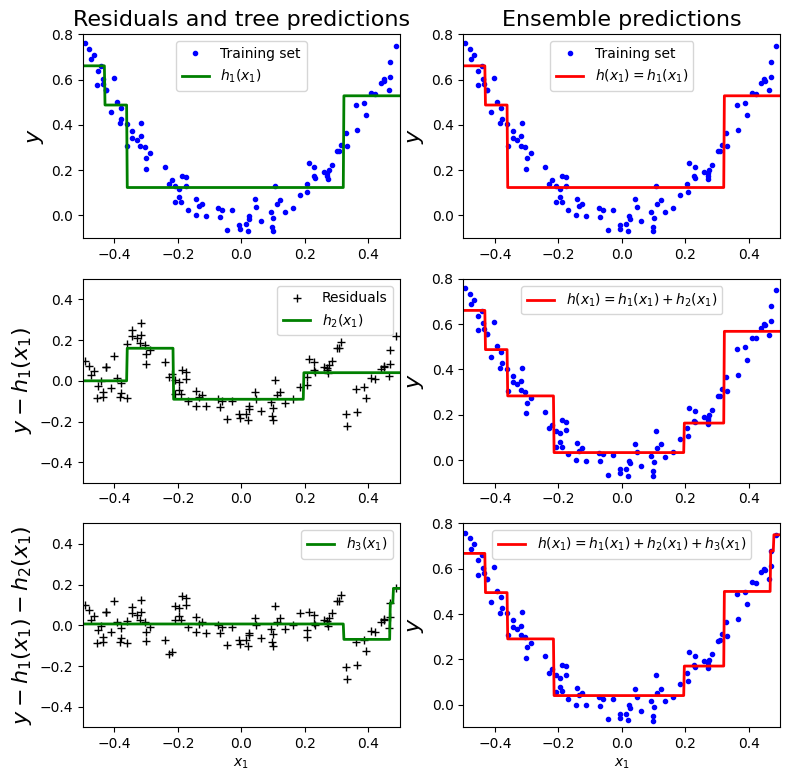

In [ ]:
mpl.rcParams['axes.titlesize']  = 16
mpl.rcParams['ytick.labelsize'] = 10
fontsize_legends                = 10

plt.figure(figsize=(9, 9))
# -----------------------------------------------------------------------------
#                               SUBPLOT 321
# -----------------------------------------------------------------------------
ax321 = plt.subplot(321)

plot_predictions(
      [reg_1]
    , X
    , y
    , axes       = [-0.5, 0.5, -0.1, 0.8]
    , label      = "$h_1(x_1)$"
    , style      = "g-"
    , data_label = "Training set"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
)

plt.title(
      "Residuals and tree predictions"
    , fontsize = 16
)

ax321.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 322
# -----------------------------------------------------------------------------
ax322 = plt.subplot(322)

plot_predictions(
      [reg_1]
    , X
    , y
    , axes       = [-0.5, 0.5, -0.1, 0.8]
    , label      = "$h(x_1) = h_1(x_1)$"
    , data_label = "Training set"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
)

plt.title(
      "Ensemble predictions"
)

ax322.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 323
# -----------------------------------------------------------------------------
ax323 = plt.subplot(323)

plot_predictions(
      [reg_2]
    , X
    , y_res1
    , axes       = [-0.5, 0.5, -0.5, 0.5]
    , label      = "$h_2(x_1)$"
    , style      = "g-"
    , data_style = "k+"
    , data_label = "Residuals"
)

plt.ylabel(
      "$y - h_1(x_1)$"
    , fontsize = 16
)

ax323.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 324
# -----------------------------------------------------------------------------
ax324 = plt.subplot(324)

plot_predictions(
      [reg_1, reg_2]
    , X
    , y
    , axes  = [-0.5, 0.5, -0.1, 0.8]
    , label = "$h(x_1) = h_1(x_1) + h_2(x_1)$"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
)

ax324.legend(
      fontsize = fontsize_legends
)# -----------------------------------------------------------------------------
#                               SUBPLOT 325
# -----------------------------------------------------------------------------
ax325 = plt.subplot(325)

plot_predictions(
      [reg_3]
    , X
    , y_res2
    , axes       = [-0.5, 0.5, -0.5, 0.5]
    , label      = "$h_3(x_1)$"
    , style      = "g-"
    , data_style = "k+"
)

plt.xlabel(
      "$x_1$"
)

plt.ylabel(
      "$y - h_1(x_1) - h_2(x_1)$"
    , fontsize = 16
)

ax325.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 326
# -----------------------------------------------------------------------------
ax326 = plt.subplot(326)

plot_predictions(
      [reg_1, reg_2, reg_3]
    , X
    , y
    , axes  = [-0.5, 0.5, -0.1, 0.8]
    , label = "$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$"
)

plt.xlabel(
      "$x_1$"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
)

ax326.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
# save_fig("gradient_boosting_plot")
plt.show()

# 2. Classification

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a <b>classification</b> problem. Specifically, the <b>Titanic dataset</b> ( <a href="https://github.com/mehrdadmohsenizadeh/SB_DS/blob/main/14.%20Supervised%20Learning/14.5.%20Ensemble%20Methods%3A%20Gradient%20Boosting%20and%20AdaBoost/data/titanic.csv"><code><b>../data/titanic.csv</b></code></a>) and predicting survival.

## 2.1. Load data

Use pandas <code><b>read_csv()</b></code> method to load in the Titantic data set into a dataframe object called <code><b>df</b></code> .

> <b>Hint:</b> In this case, you can use <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html"><code><b>dropna()</b></code></a> to just throw away any incomplete rows. For the purpose of this exercise, we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations.

In [ ]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/data/14.5.titanic.csv"
).dropna()

## 2.2. Visualize

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


Print the levels of the categorical data using <code><b>select_dtypes()</b></code> . The <code><b>df.info()</b></code> revealed that the categorical features in this dataset have a data type of <code><b>object</b></code> .

In [ ]:
# Select columns of dtype 'object'
df_cols_obj = df.select_dtypes(
    include = ['object']
)

In [ ]:
# Loop through the selected categorical columns and print unique levels
for col in df_cols_obj.columns:

    unique_levels = df_cols_obj[col].unique()

    # Prettify the output
    print(f"Unique levels in feature '{col}':")
    for unique_level in unique_levels:
        print(f"  - {unique_level}")

Unique levels in feature 'Name':
  - Cumings, Mrs. John Bradley (Florence Briggs Thayer)
  - Futrelle, Mrs. Jacques Heath (Lily May Peel)
  - McCarthy, Mr. Timothy J
  - Sandstrom, Miss. Marguerite Rut
  - Bonnell, Miss. Elizabeth
  - Beesley, Mr. Lawrence
  - Sloper, Mr. William Thompson
  - Fortune, Mr. Charles Alexander
  - Harper, Mrs. Henry Sleeper (Myna Haxtun)
  - Ostby, Mr. Engelhart Cornelius
  - Harris, Mr. Henry Birkhardt
  - Nye, Mrs. (Elizabeth Ramell)
  - Moen, Mr. Sigurd Hansen
  - Fortune, Miss. Mabel Helen
  - Chaffee, Mr. Herbert Fuller
  - Goldschmidt, Mr. George B
  - Greenfield, Mr. William Bertram
  - White, Mr. Richard Frasar
  - Porter, Mr. Walter Chamberlain
  - Baxter, Mr. Quigg Edmond
  - Webber, Miss. Susan
  - White, Mr. Percival Wayland
  - Newsom, Miss. Helen Monypeny
  - Futrelle, Mr. Jacques Heath
  - Giglio, Mr. Victor
  - Navratil, Mr. Michel ("Louis M Hoffman")
  - Pears, Mrs. Thomas (Edith Wearne)
  - Van der hoef, Mr. Wyckoff
  - Smith, Mr. James C

## 2.3. Feature Engineering

Create dummy features for the categorical features and add those to the dataframe <code><b>df</b></code> . Make sure to also remove the original categorical columns from the <code><b>df</b></code> .

In [ ]:
try:
  # 1. Remove specified columns df_cols_obj from df.
  # 2. Convert categorical columns ('Name', 'Cabin', 'Ticket') into one-hot encoded columns.
  # 3. Drop the 'PassengerId' column from the resulted DataFrame.
  df = df.drop(df_cols_obj.columns, axis=1)\
      .join(pd.get_dummies(df_cols_obj.drop(['Name', 'Cabin', 'Ticket'], axis=1)))\
      .drop('PassengerId', axis=1)
except:
  pass

In [ ]:
df.shape

(183, 11)

In [ ]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
10,1,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,1,58.0,0,0,26.5500,1,0,0,0,1


Print the null values for each column in the dataframe <code><b>df</b></code> .

In [ ]:
df\
.isnull()\
.sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

## 2.4. Features and Target variable

Create the matrix <code><b>X</b></code> and vector <code><b>y</b></code> from the dataframe <code><b>df</b></code>, where:
* The <code><b>"df[Survived]"</b></code> column is selected as the target vector <code><b>y</b></code> .
* All remaining columns are considered to be our Features matrix <code><b>X</b></code>.

In [ ]:
y = df["Survived"]

In [ ]:
# All other columns in "df" than "Survived" are assumed to be our features.
X = df.drop(
      'Survived'
    , axis = 1
)

## 2.5. Feature scaling

Apply the <code><b>StandardScaler()</b></code> to the <code><b>X</b></code> matrix and call the trasformed data <code><b>X_scaled</b></code> .

In [ ]:
X_scaled = preprocessing\
          .StandardScaler()\
          .fit_transform(X)

## 2.6. Train/Test split (<code><b>X</b></code> and <code><b>y</b></code>)

Split the scaled features <code><b>X_scaled</b></code> and <code><b>y</b></code> into $75/25$ training and testing data subsets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
      X_scaled
    , y
    , train_size   = 0.75
    , random_state = 1
)

## 2.7. Best Learning Rate

Run the cell below to test multiple learning rates in your <code><b>GradientBoostingClassifier</b></code> .

In [ ]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

In [ ]:
best_learning_rate       = None
best_validation_accuracy = 0

for learning_rate in learning_rates:

    gb = GradientBoostingClassifier(
          n_estimators  = 20
        , learning_rate = learning_rate
        , max_features  = 2
        , max_depth     = 2
        , random_state  = 0
    )

    gb.fit(
          X_train
        , y_train
    )

    training_accuracy = gb.score(
          X_train
        , y_train
    )

    validation_accuracy = gb.score(
          X_test
        , y_test
    )

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

    # Check if the current model has the best validation accuracy
    if validation_accuracy > best_validation_accuracy:
        best_learning_rate       = learning_rate
        best_validation_accuracy = validation_accuracy

Learning rate:  0.05
Accuracy score (training): 0.715
Accuracy score (validation): 0.652

Learning rate:  0.1
Accuracy score (training): 0.847
Accuracy score (validation): 0.739

Learning rate:  0.25
Accuracy score (training): 0.876
Accuracy score (validation): 0.739

Learning rate:  0.5
Accuracy score (training): 0.898
Accuracy score (validation): 0.739

Learning rate:  0.75
Accuracy score (training): 0.905
Accuracy score (validation): 0.761

Learning rate:  1
Accuracy score (training): 0.912
Accuracy score (validation): 0.696



> <b>NOTE:</b> The <b>best learning rate</b> is the one that resulted in the <b>highest validation accuracy</b>. In our case, the <code><b>Learning rate = 0.75</b></code> achieved the highest validation accuracy, i.e., <code><b>Accuracy score (validation) = 0.761</b></code> .

In [ ]:
print("Best Learning Rate:", best_learning_rate)
print("Best Validation Accuracy:", round(best_validation_accuracy, 3))

Best Learning Rate: 0.75
Best Validation Accuracy: 0.761


## 2.8. Build

Build (initialize) a <code><b>GradientBoostingClassifier</b></code> model with the <code><b>best_learning_rate</b></code>, and call the model the <code><b>best_gb</b></code> .

In [ ]:
# Initialize the model with the best learning rate
best_gb = GradientBoostingClassifier(
      n_estimators  = 20
    , max_features  = 2
    , max_depth     = 2
    , random_state  = 0
    , learning_rate = best_learning_rate
)

## 2.9. Fit

<code><b>fit</b></code> the <code><b>best_gb</b></code> model on the training data <code><b>(X_train, y_train)</b></code> .

In [ ]:
# Fit on the training data
best_gb.fit(
      X_train
    , y_train
)

GradientBoostingClassifier(learning_rate=0.75, max_depth=2, max_features=2,
                           n_estimators=20, random_state=0)

## 2.10. Predict

<code><b>predict</b></code> the <code><b>best_gb</b></code> model on the testing set <code><b>X_test</b></code> .

In [ ]:
y_pred = best_gb.predict(
    X_test
)

## 2.11. Evaluate

### Confusion matrix

Plot the confusion matrix for <code><b>(y_test, y_pred)</b></code> .

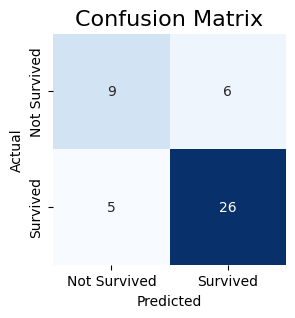

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(
      y_test
    , y_pred
)

# Define the class labels (0: Not survived, 1: Survived)
class_labels = [
      'Not Survived'
    , 'Survived'
]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(3, 3))

sns.heatmap(
      cm
    , fmt         = 'd'
    , annot       = True
    , cmap        = 'Blues'
    , cbar        = False
    , xticklabels = class_labels
    , yticklabels = class_labels
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

### Classification report

Print out the classification report for <code><b>(y_test, y_pred)</b></code> to review the model performance.

In [ ]:
class_report = classification_report(
      y_test
    , y_pred
)

print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.81      0.84      0.83        31

    accuracy                           0.76        46
   macro avg       0.73      0.72      0.72        46
weighted avg       0.76      0.76      0.76        46



### ROC curve

Calculate the ROC for the model as well. To do this end, we:

1. Calculate the predicted probabilities for class 1 (Survived) using the <code><b>predict_proba</b></code> method .

2. Use the <code><b>roc_curve</b></code> function to compute the ROC curve, which returns the false positive rate (<code><b>fpr</b></code>), true positive rate (<code><b>tpr</b></code>), and thresholds.

3. Calculate the AUC (Area Under the ROC Curve) using the <code><b>roc_auc_score</b></code> function.

In [ ]:
# Calculate the predicted probabilities for class 1 (Survived)
y_prob = best_gb\
         .predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(
      y_test
    , y_prob
)

# AUC
roc_auc = roc_auc_score(
      y_test
    , y_prob
)

### Plot ROC curve

This code will generate and display the <b>ROC curve</b> for the model, along with the <b>AUC score</b>, allowing us to assess the model's performance in terms of classification thresholds and the trade-off between true positives (TPs) and false positives (FPs).

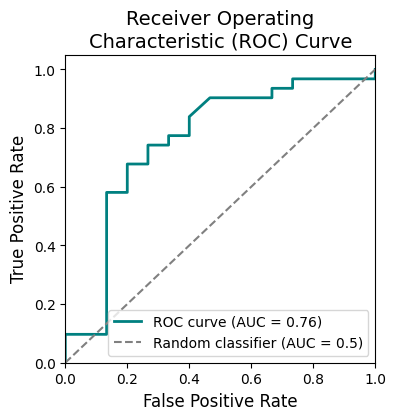

In [ ]:
plt.figure(figsize=(4, 4))
# -----------------------------------------------------------------------------
# ROC curve
plt.plot(
      fpr
    , tpr
    , color = 'teal'
    , label = f'ROC curve (AUC = {roc_auc:.2f})'
    , lw    = 2
)
# -----------------------------------------------------------------------------
# Random classifier (AUC = 0.5) as the baseline (or reference)
plt.plot(
      [0, 1]
    , [0, 1]
    , color     = 'gray'
    , label     = 'Random classifier (AUC = 0.5)'
    , linestyle = '--'
)
# -----------------------------------------------------------------------------
plt.xlim(
    [0.0, 1.00]
)

plt.ylim(
    [0.0, 1.05]
)
# -----------------------------------------------------------------------------
plt.xlabel(
      'False Positive Rate'
    , fontsize = 12
)

plt.ylabel(
      'True Positive Rate'
    , fontsize = 12
)
# -----------------------------------------------------------------------------
plt.title(
      'Receiver Operating\nCharacteristic (ROC) Curve'
    , fontsize = 14
)

plt.legend(
    loc='best'
)
# -----------------------------------------------------------------------------
plt.show()

## 2.12. Results & Conclusions

Now, we break down the key metrics in the classification report. First, let's review what each metric means:

1. The <code><b>precision</b></code> measures how many of the positive predictions made by the model were actually correct. A higher value indicates that the model makes fewer false positive predictions.

2. The <code><b>recall</b></code> measures how many of the actual positive instances were correctly predicted by the model. A higher value indicates that the model captures more of the positive instances.

3. The <code><b>f1-score</b></code> is the harmonic mean of <code><b>precision</b></code> and <code><b>recall</b></code> and provides a single score that balances both metrics. A higher score indicates a better balance between the two metrics.

4. The <code><b>support</b></code> indicates the number of actual instances for each class in your dataset. In your case, there are <code><b>15</b></code> instances of class <code><b>0</b></code> and <code><b>31</b></code> instances of class <code><b>1</b></code>.

5. <code><b>accuracy</b></code> measures the overall correctness of the model's predictions across all classes. In this case, the overall accuracy is <code><b>0.76</b></code>, which means that the model correctly predicted $76\%$ of the instances in the dataset.



6. <code><b>Macro Avg</b></code> and <code><b>Weighted Avg</b></code>are average values calculated for <code><b>precision</b></code>, <code><b>recall</b></code>, and <code><b>f1-score</b></code>.
  
  * <code><b>Macro Avg</b></code> takes the unweighted mean of those metrics across all $N$ classes in the target.

  \begin{align}
  \large\text{Macro Avg } \textit{{metric_name}}
  =
  \large\frac{1}{n}
  \sum_{i=0}^{N}{\textit{{metric_name}}_{\textbf{class}_i}} \tag{3}
  \end{align}

  * <code><b>Weighted Avg</b></code> takes a weighted mean based on the <code><b>support</b></code> of each class:

  \begin{align}
  \large\text{Weighted Avg } \textit{{metric_name}}
  =
  \large\frac{1}{total\_{support}}
  \sum_{i=0}^{N}{\Bigg[\textit{{metric_name}}_{\textbf{class}_i} \times \textit{{support}}_{\textbf{class}_i}\Bigg]} \tag{4}
  \\\\ \notag{}
  \textit{{metric_name}} \in \{precision, recall, f1-score\} \notag{}
  \end{align}

* <b>AUC Value:</b> A numerical value that represents the overall performance of a binary classification model.

* <b>ROC Curve:</b> A graphical representation of a model's performance across different $\small\textbf{threshold}$ values for classifying instances.

> <b>Conclusions:</b>
>
> This classification report indicates that our model performs reasonably well:
  >* It has higher <code><b>precision</b></code> and <code><b>recall</b></code> for class <code><b>1</b></code> compared to class <code><b>0</b></code> .
  >
  >* The <code><b>f1-score</b></code> for class <code><b>1</b></code> is relatively high, indicating good balance between <code><b>precision</b></code> and <code><b>recall</b></code> for that class. However, for class <code><b>0</b></code>, the <code><b>f1-score</b></code> is lower, indicating a less balanced performance for that class.
  >
  >* The overall <code><b>accuracy</b></code> is $76\%$, which means the model makes correct predictions for about $76\%$ of the instances in the dataset.
  >
  > Additionally, from the AUC value and ROC curve we can infer that:
  >
  >* An AUC of <code><b>0.76</b></code> suggests that the model is better than random chance at distinguishing between the two classes. A <b>perfect model</b> would have an AUC of <code><b>1.0</b></code>, while a <b>random model</b> would have an AUC of <code><b>0.5</b></code>. So, an AUC of <code><b>0.76</b></code>6 indicates that the model has a significant degree of discrimination ability.
  >
  >* With an AUC of 0.76, we would typically expect the ROC curve to show a moderate separation between the true positive rate (sensitivity) and the false positive rate (1-specificity). The curve may not be perfect, but it shows that the model has some discriminative power.